Name: Nhung Hong Le 

School: NYU's Center for Data Science

Email: nhl256@nyu.edu

# Executive Summary

A leader in the F&B industry is trying to optimize its marketing actions. The goal of this project is to provide valuable ínsights on how sales of different brands and products respond to promotions and different marketing features applied in each promotion. Should we find significant marketing features on each product / brand, it would be interesting to build a predictive model that would maximize sales for each product.

Inputs are five sets of data: 

    1. Daily sales data by products
    2. A mapping of products to brands
    3. Daily out-of-stock (oos) signal by product
    4. Marketing campaign start dates and binary features for products
    5. Marketing campaign start dates and binary features for entire brands
  
A careful data exploration process sheds light on the following main findings:

**1. Brand promotions significantly influence aggregated brand sales but no specific marketing feature matters.** 

I used a mulitple linear regression with explanatory variables $X$ to be marketing features f0, f1, ..., f29 and dependent variable $Y$ to be percent change in sales between 5 days before promotions and 5 days after promotions. The choice of the number of day (in this case 5 days) does not affect the conclusion drawn from the regression result. The model has a low R-squared value of 0.017 indicating that this model explains 1.7% of the variance in our percent changes in sales before and after promotions. At 5% significance level, only the intercept is significant with p value < 0.05. This means that the act of having a promotion has a statistically significant impact on sales, but no specific marketing feature contributes significantly to the impact of promotions. 


**2. Product promotions influence product sales but no specific marketing feature does.** 

I also ran a mulitple linear regression with explanatory variables $X$ to be marketing features f0, f1, ..., f29 and dependent variable $Y$ to be percent change in sales between 5 days before and 5 days after product promotions. The choice of the number of day (in this case 5 days) does not affect the conclusion drawn from the regression result. The model has a low R-squared value of 0.006 indicating that this model explains 0.6% of the variance in our percent changes in sales before and after promotions. At 5% significance level, only the intercept is significant with p value < 0.05. This means that the act of having a promotion has a statistically significant impact on sales, but no specific marketing feature contributes significantly to the impact of promotions. 

**3. Durations of aggregated brand promotions vary by brand. The aggregated duration of all brand promotions is 23 days **

Given the time frame of 30 days before and 30 days after brand promotions, durations of aggregated brand promotions vary by brand. For example, total sales of brand 0 fall back to the sales level before brand promotions after about 20 days, while the durations of brand promotions of brand 1, 24, 39 are 15 days, 18 days, and 25 days respectively. I chosed the time frame of 30 days before and 30 days after the brand promotions after examining different options of time windows (e.g., 10, 20, 30, 40) and realize that given different economic forces of different brands and various marketing features, the window of 30 days before and after promotions seems to be the average length to observe any marketing effects on brand sales. 

As shown in the graph below, total sales of all brands seem to get back to its normal cycle 23 days after brand promotions. Thus, the aggregated duration of all brand promotions is 23 days.

!['Brand 0 Sales Changes'](duration_all_brands.png)

# Problem formulation

We aim to build a descriptive model that can best describe the responses of sales of each products and brands to promotions, thus to utilize marketing features to maximize sales of various products. 

This is an open-ended problem with multiple possible directions to go, so it is important to define some specific goals before conducting any analyses. 

### Business goal: 

To utilize brand and product promotions that maximize sales. 

### Data science goals: 

1. To build a descriptive model that provides insights on impacts of different marketing features on specific products of specific brand.
2. To build a predictive model to estimate sales of specific products given the marketing features applied to them.
3. By achieving 1. and 2., we can predict sales for each product of each brand using a model that most utilize marketing features. In other words, if we apply most effective marketing features to certain product of certain brand, how much sales would have been achived. 


# Data Exploration

Since there are two types of promotions **brand promotions** and **product promotions**, it is reasonable to understand the impact of promotions on sales of products at two promotion levels of brands and products.

- At brand level, I conducted data analyses to understand the following: 
    - Effects of promotions as a whole on total sales of the entire brand
    - Effects of one single marketing feature on total sales of products of each brand
    - The length of each promotion for each brand
    - Effect of all marketing features on total sales of products of each brand

- At product level, I conducted data analyses to gain insights on the following:
    - Effect of all marketing features on total sales of products of each brand

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import statsmodels.api as sm

In [7]:
brand_promo_org = pd.read_csv("brand_promotions.csv")
daily_oos_org = pd.read_csv("daily_product_oos.csv")
daily_sales_org = pd.read_csv("daily_product_sales.csv")
product_brand_map_org = pd.read_csv("product_brand_map.csv", header=None)
product_promo_org = pd.read_csv("product_promotions.csv")

## 1. Data Cleaning and Basic Information

In [8]:
product_promo = product_promo_org.copy()
product_promo['product'].value_counts().sum()
product_promo = product_promo.sort_values(['product', 'start_date'])
unique_product = len(product_promo['product'].sort_values().unique())
num_promo = product_promo['product'].value_counts().sum()
print("number of unique products that have product promotions:{}".format(unique_product))
print("number of product promotions:{}".format(num_promo))

number of unique products that have product promotions:9106
number of product promotions:23985


In [9]:
brand_promo = brand_promo_org.copy()
brand_promo = brand_promo.sort_values(['brand', 'start_date'])
print("Number of unique brands that have brand promotions: {}".format(len(brand_promo['brand'].sort_values().unique())))
print("Number of brand promotions: {}".format((brand_promo['brand'].value_counts().sum())))

Number of unique brands that have brand promotions: 40
Number of brand promotions: 6015


In [10]:
product_brand_map = product_brand_map_org.copy()
product_brand_map.columns = ['product', 'brand']

In [11]:
print('Number of unique brands: {}'.format(product_brand_map['brand'].nunique()))

Number of unique brands: 40


In [12]:
daily_oos = daily_oos_org.copy()
daily_oos = daily_oos.rename(columns = {'Unnamed: 0': 'product'})
daily_sales = daily_sales_org.copy()
daily_sales = daily_sales.rename(columns = {'Unnamed: 0': 'product'})

A preliminary data exploration gives the following information of each dataset, which may prove useful for this. 
1. Brand Promotions: There are 40 unique brands, with 6,015 promotions. For each promotion, some marketing features from f0 to f29 are applied. 
2. Product Promotions: There are 9106 unique products, with 23,985 promotions. For each promotion, some marketing features from f0 to f29 are applied. Since there are 10000 products, and promotions for only 9106 unique products, we know that 894 products never had any promotions. 
3. Product_brand_map: There are 10000 products of 40 brands.

### 1A. Create a master daily sales by product 

In [13]:
# Create a master daily sales that inlucdes both product and brand
daily_sales = pd.merge(daily_sales, product_brand_map, how = 'left', on = 'product')
cols = daily_sales.columns.tolist()
new_cols = []
new_cols.append(cols[0])
new_cols.append(cols[-1])
new_cols = new_cols + cols[1:-1]
daily_sales = daily_sales[new_cols]

In [14]:
num_by_brand = daily_sales.groupby('brand')['product'].nunique().reset_index().T

### 1B. Filling missing data

On days that a product is out of stock, sales could be recorded as NA or 0. We want to fill in sales for these out-of-stock days as sales of non-out-of-stock days. So at first we will assign NA as sales of out-of-stock days

In [16]:
#### Make oos dates -> NA
daily_sales.iloc[:, 2:] = daily_sales.iloc[:, 2:] + daily_oos.iloc[:, 1:].replace(1.0, np.nan)

We can fill missing sales values with sales of a previous day that has sales value. It is because for the case of out-of-stock days, the day a product is available again, its sales would increase significantly as we need to fill in back-log orders. As a result, it is more reasonable to assume that sales of these out-of-stock days would be similar to sales of the previous non-out-of-stock day. 

Note that this filling NA method is not ideal because it is possible that the previous day with non-missing-sales could be a promotion day when sales increases. However, given the current scenario, this filling NA method of previous day's sales is most applicable.

In [17]:
daily_sales[['2012-03-01']] = daily_sales[['2012-03-01']].fillna(value = 0)
daily_sales = daily_sales.transpose().fillna(method='ffill').transpose()

## 2. Brand 0 - A specific case

Given 10000 products from 40 brands, and that each product and brand have a different curve, it makes sense to look at all products of brand 0 to investigate the following points:
    1. Impacts of promotions on brand 0
    2. Impacts of each marketing feature f0, f1..., f29 on brand 0 as a whole
    3. The average length of brand 0 promotions

In [18]:
brand_0 = daily_sales[daily_sales['brand'] == 0]
dates = brand_0.columns[2:]

In [19]:
print('Number of products of brand 0: {}'.format(brand_0.shape[0]))
print('Number of dates: {}'.format(len(dates)))

Number of products of brand 0: 253
Number of dates: 1433


In [20]:
brand_0.head()

,product,brand,2012-03-01,2012-03-02,2012-03-03,2012-03-04,2012-03-05,2012-03-06,2012-03-07,2012-03-08,...,2016-01-23,2016-01-24,2016-01-25,2016-01-26,2016-01-27,2016-01-28,2016-01-29,2016-01-30,2016-01-31,2016-02-01
0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,4.0,4.0,4.0,4.0,3.0,4.0,4.0,5.0,4.0,3.0
28,28.0,0.0,0.0,1.0,2.0,1.0,1.0,2.0,2.0,1.0,...,16.0,16.0,16.0,16.0,16.0,16.0,16.0,13.0,14.0,14.0
48,48.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,...,10.0,10.0,13.0,11.0,11.0,11.0,11.0,11.0,11.0,10.0
49,49.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.0,1.0,1.0,1.0,1.0,1.0,1.0,4.0,1.0,1.0
65,65.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,6.0,6.0,9.0,7.0,5.0,7.0,7.0,7.0,6.0,7.0


### 2A: Aggregate impacts of brand promotion on brand 0 - raw sales data

In [21]:
brand_0_total = brand_0.sum()[2:]

In [22]:
all_dates = [datetime.datetime.strptime(i, '%Y-%m-%d') for i in dates]

In [23]:
# plotBrandPromotion Function                                                   
# Goal: Plot percentage changes of sales from num_days befor to num_days after promotions   
# num_days: int, number of days before / after promotions                                  
# my_dates: date-time, list of promotion dates                                            
# sales_total: dataframe, sales records across all dates                                   
# -----------------------------------------------------------------------------------------
def plotBrandPromotion(num_days, my_dates, sales_total, brand_num):
    sale_by_date = [0 for i in range(num_days * 2 + 1)]
    for date in my_dates:
        date_index = all_dates.index(date)
        if date_index < num_days or date_index + num_days >= len(all_dates):
            continue
        for i in range(num_days * 2 + 1):
            sale_by_date[i] += sales_total[date_index - num_days + i]
    avg_prior_sales = float(np.mean(sale_by_date[:num_days]))
    if avg_prior_sales == 0:
        return ('avg 0')
    sale_by_date = [(s / avg_prior_sales) for s in sale_by_date]
    sns.lineplot(y=sale_by_date, x= [i - num_days for i in range(num_days * 2 + 1)])
    plt.title('Total sales of brand {} from {} days before to {} days after promotions'.format(brand_num, num_days, num_days))
    plt.xlabel('Days')
    plt.show()

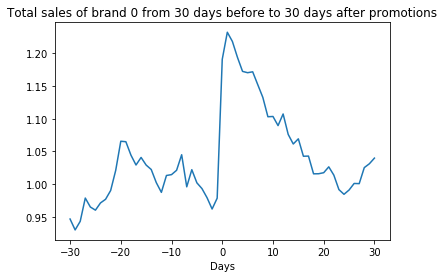

In [24]:
my_dates = brand_promo[(brand_promo['brand'] == 0)]['start_date'].tolist()
my_dates = [datetime.datetime.strptime(d, '%Y-%m-%d') for d in my_dates]
plotBrandPromotion(num_days = 30, my_dates = my_dates, sales_total = brand_0_total, brand_num = 0)

As shown in the graph above, on day 0 when promotions happened, we see a significant change in total sales, which often last for 2 days before sales starts decreasing.

Worrying that different products of brand 0 would have different sales curves (e.g., product 28 has 1000 unit sales while product 0 has only 10), then a change in terms of quantity of a product thanks to the promotions will not be acknowledged. For example, an increase of 2 units in sales of product 0, which means 20% increase in sales or a significant impact of brand promotion would not affect the aggregate sales of brand 0.

Please note that as the goal of any businesses is to maximize its profits, so when it comes to any changes in sales units given any factors (e.g., promotions), the products that lead to more profits will get the priority. 

Thus, it is possible to normalize sales of all products in brand 0. The normalization method applied here is for each product, we can divide each daily sales by the mean of daily sales of that product. 

### 2B. Aggregate impacts of brand promotion on brand 0 - normalized sales data

In [28]:
brand_0_normal = brand_0.apply(lambda x: x[0:2].append(x[2:] / np.mean(x[2:])), axis=1)
brand_0_normal_total = brand_0_normal.sum()[2:]

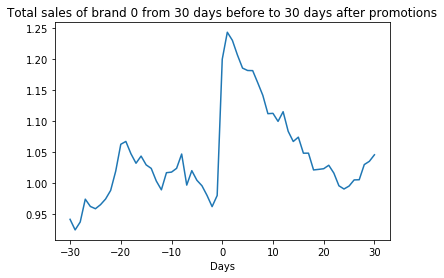

In [29]:
my_dates = brand_promo[(brand_promo['brand'] == 0)]['start_date'].tolist()
my_dates = [datetime.datetime.strptime(d, '%Y-%m-%d') for d in my_dates]
plotBrandPromotion(num_days = 30, my_dates = my_dates, sales_total = brand_0_normal_total, brand_num = 0)

We see that the aggregate sales of normalized sales of brand 0 does not differ the aggregate sales of non-normalized sales of brand 0 much. It is possibly because products of brand 0 do not differ too much (i.e., relatively low standard deviation). We confirm this hypothesis as shown below.

In [30]:
brand_0.apply(lambda x: np.mean(x[2:]), axis=1).describe()

count    253.000000
mean      45.409037
std       18.506643
min       25.602233
25%       31.241452
50%       38.194696
75%       55.235869
max      118.671319
dtype: float64

### 2C. Duration of aggregated promotions for brand 0

In order to investigate the length of each promotion, we want to see when the sales of the brand fall back into its sales level before the promotion happened. In the graphs below, I was interested in the effect of having promotions, so I considered all promotion as one and changed num_days variable to see how long it would take for total sales of brand 0 to get back to its sales level before the promotion. The graphs suggest that after 20 days of the promotion, sales of brand 0 felt back to its sales level before the promotion took place, when percentage change in total sales of brand 0 falls back to 100%.

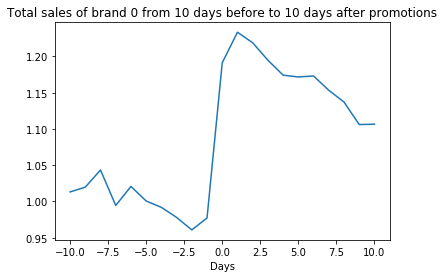

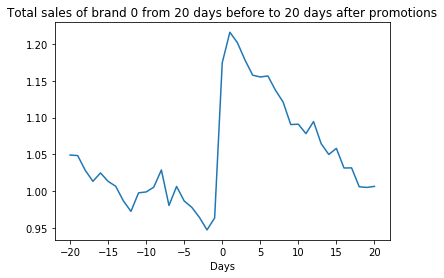

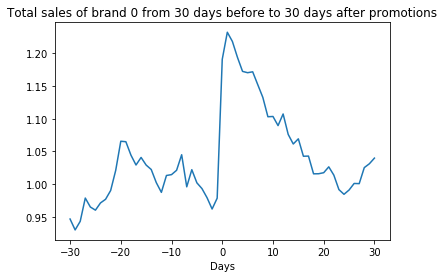

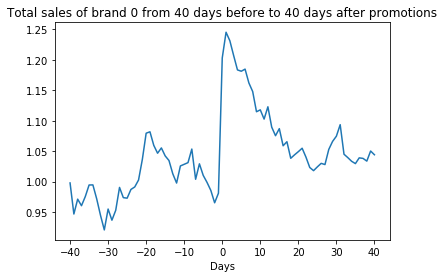

In [31]:
num_days_list = [10, 20, 30, 40]
for num_days in num_days_list: 
    plotBrandPromotion(num_days = num_days, my_dates = my_dates, sales_total = brand_0_total, brand_num = 0)

### 2D. Durations of each of the promotions for brand 0

We can apply similar approach to investigate the length of any specific promotion.

The graphs below demonstrate percentage changes of brand 0 sales after the promotion on 2012-04-02. At day 25 after the promotion, sales of brand 0 fall back to the sales level before the promotion took place. So for this specific promotion on 2012-04-02, we may say that the length of the promotion is 25 days. 

It is interesting to see that sales of brand 0 increased significantly 30 days after the promotion, which is potentially because of another promotion on 2012-05-01, or any special event on 2012-05-01 that led to such a change in sales.

In [32]:
def LenBrandPromotion(num_days, promo_date, sales_total, num_days_before=10):
    sale_by_date = [0 for i in range(num_days_before + num_days)]
    date_index = all_dates.index(promo_date)
    if date_index < num_days or date_index + num_days >= len(all_dates):
        return np.nan
    for i in range(num_days_before + num_days):
        sale_by_date[i] += sales_total[date_index - num_days_before + i]
    avg_prior_sales = float(np.mean(sale_by_date[:num_days_before]))
    sale_by_date = [(s / avg_prior_sales) for s in sale_by_date]
    for i in range(num_days_before, len(sale_by_date)): 
        if sale_by_date[i] <= 1.0:
            return i - num_days_before
    return num_days

In [33]:
brand_0_promo_dates = brand_promo[(brand_promo['brand'] == 0)]['start_date'].tolist()
brand_0_promo_dates = [datetime.datetime.strptime(d, '%Y-%m-%d') for d in brand_0_promo_dates]

In [34]:
len_brand_0_promo = pd.DataFrame(index = brand_0_promo_dates)

In [35]:
num_days_list = [30]
for num_days in num_days_list:
    len_promo = []
    for date in brand_0_promo_dates:
        len_promo.append(LenBrandPromotion(num_days = num_days, promo_date=date, sales_total = brand_0_normal_total))
    len_brand_0_promo['len_promo_{}'.format(num_days)] = len_promo

Given the time window of 30 days before and 30 days after each brand promotion, the table below shows duration of each brand promotion day.

### 2E. Aggregate impacts of marketing features on brand 0

There are 151 promotions applied to brand 0 from 2012-03-01 to 2016-02-01, each includes different marketing features. To gain some insights on the impact of each brand feature, we can look at changes in aggregae sales $n$ days before and $n$ days after that specific marketing feature is on.

In [36]:
# SaleByDate Function                                            
# Goal: Return a list of sales by date in terms of average sales of num_days 
#       prior to promotion with or without feature fi
# num_days: int, number of days before / after promotions                                                                          
# sales_total: dataframe, sales records across all dates    
# i: int, feature (e.g., f1, f2,...)
# feature_on: feature fi is on if feature_on = True
# -----------------------------------------------------------------------------------------

def SaleByDate(num_days, sales_total, i, feature_on = True):
    feature = 'f{}'.format(i)
    my_dates = brand_promo[(brand_promo['brand'] == i) & 
                           (brand_promo[feature] == feature_on)]['start_date'].tolist()
    my_dates = [datetime.datetime.strptime(d, '%Y-%m-%d') for d in my_dates]
    sale_by_date = [0 for i in range(num_days * 2 + 1)]
    for date in my_dates:
        date_index = all_dates.index(date)
        if date_index < num_days or date_index + num_days >= len(all_dates):
            continue
        for i in range(num_days * 2 + 1):
            sale_by_date[i] += sales_total[date_index - num_days + i]
    avg_prior_sales = float(np.mean(sale_by_date[:num_days]))
    sale_by_date = [s / avg_prior_sales for s in sale_by_date]
    return sale_by_date

In [37]:
# plotSaleByDate Function
# Goal: Compare changes in sales when a feature on vs. when it is off
# num_days: int, number of days before / after promotions                                                                          
# sales_total: dataframe, sales records across all dates    
# i: int, feature (e.g., f1, f2,...)
# -----------------------------------------------------------------------------------------

def plotSaleByDate(num_days, sales_total, i):    
    sale_by_date_f_on = SaleByDate(num_days, sales_total, i, feature_on = True)
    sale_by_date_f_off = SaleByDate(num_days, sales_total, i, feature_on = False)
    tmp_df = pd.DataFrame({'Dates': [i - num_days for i in range(num_days * 2 + 1)],
                           'With_feature_f{}'.format(i): sale_by_date_f_on,
                           'Without_feature_f{}'.format(i): sale_by_date_f_off
                          })
    fig, ax = plt.subplots()
    ax = tmp_df.plot(ax = ax, x = 'Dates', y = 'With_feature_f{}'.format(i))
    ax = tmp_df.plot(ax = ax, x = 'Dates', y = 'Without_feature_f{}'.format(i))
    plt.title('Brand 0 Sales Chagnes')
    plt.show()

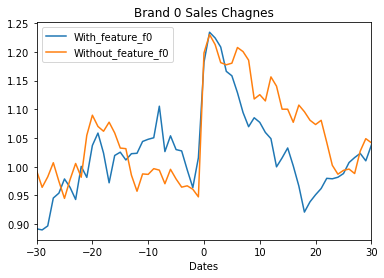

In [38]:
plotSaleByDate(num_days=30, sales_total=brand_0_total, i=0)

As shown in the graph above, feature f0 seems not to have significant impacts on brand 0 as a whole. The graph on the left shows aggregate impacts of feature F0 on brand 0. Although we see a rise in sales of brand 0 on day 0 (i.e., the day when promotions take place), we see the same change when promotions happen without feature f0. If we look closer, we can even see that sales increases more on promotions days without feature f0 than on days with feature f0, and sales decreases at a slower rate after promotions with feature f0 than it does after promtions without feature f0. Thus, we may say promotions definitely boost sales of brand 0, but feature f0 has no significant impact on brand 0.

## 3. Promotions and Brands

### 3A. Durations of aggregated brand promotions

In [39]:
num_day = 30

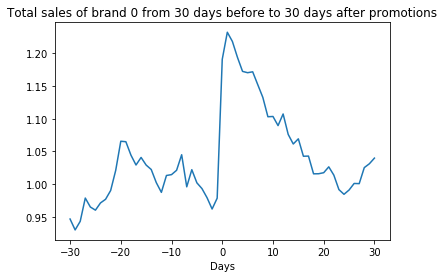

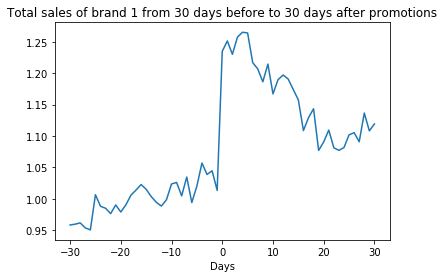

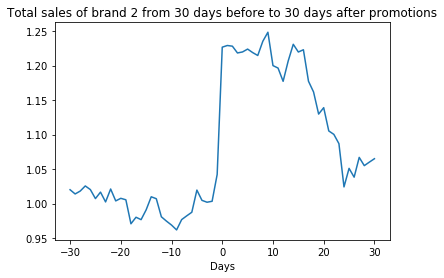

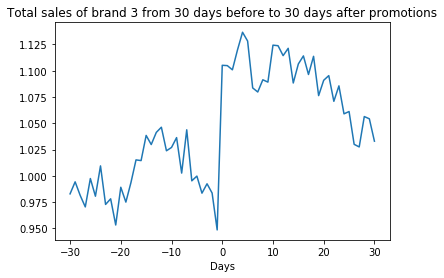

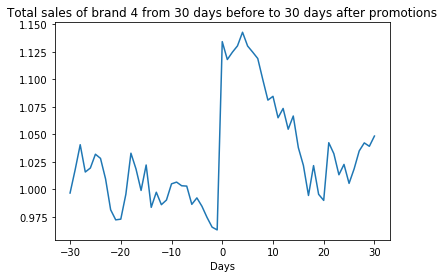

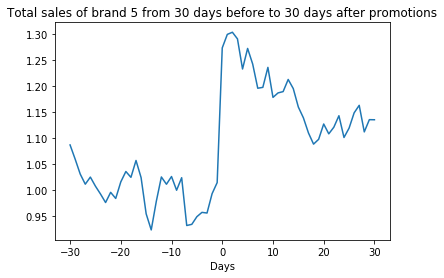

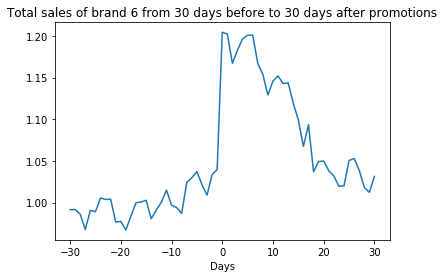

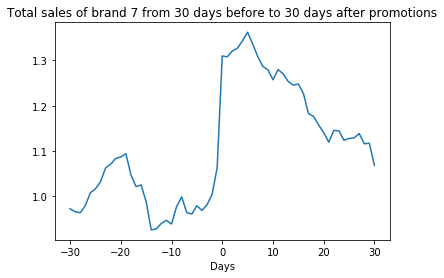

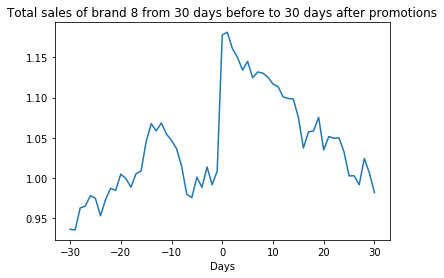

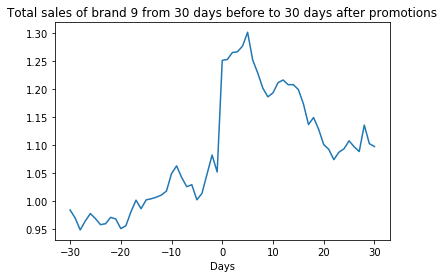

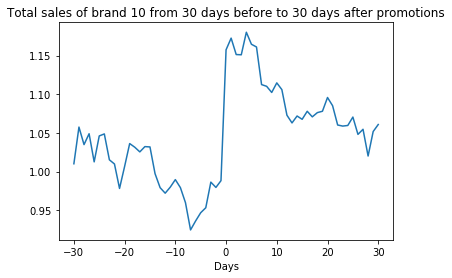

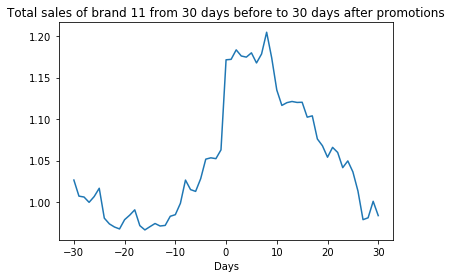

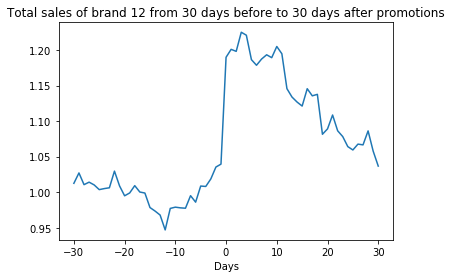

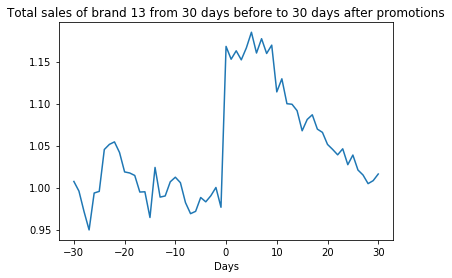

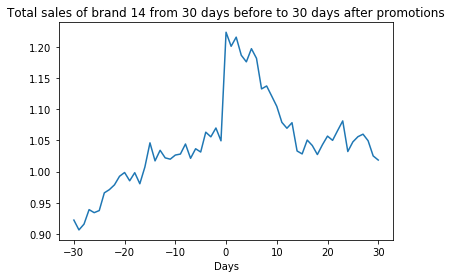

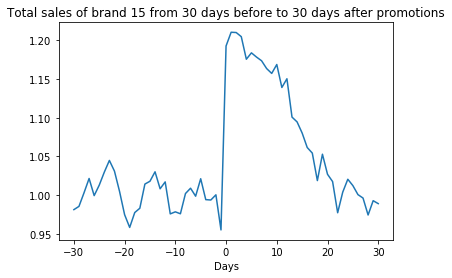

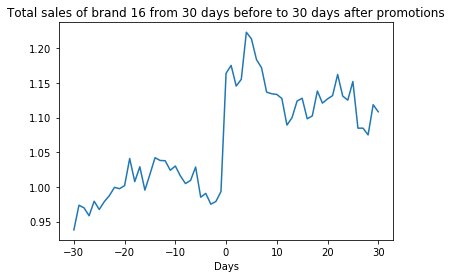

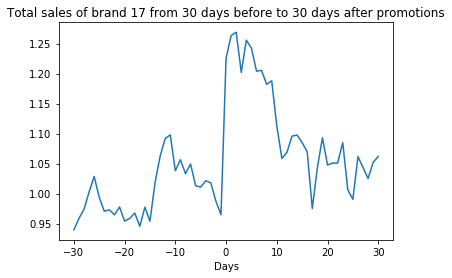

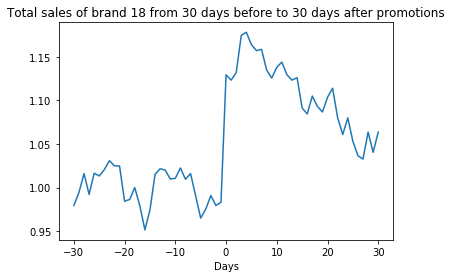

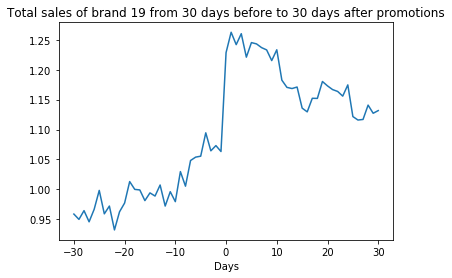

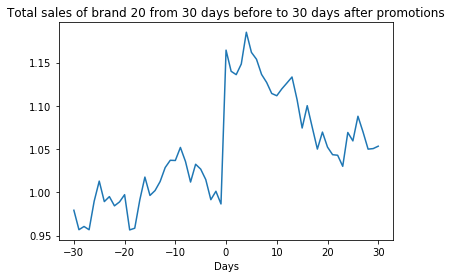

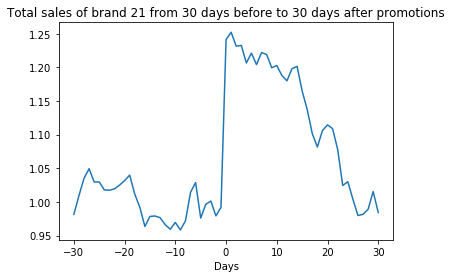

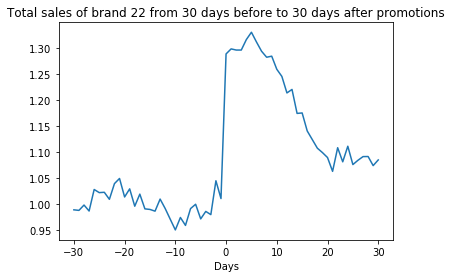

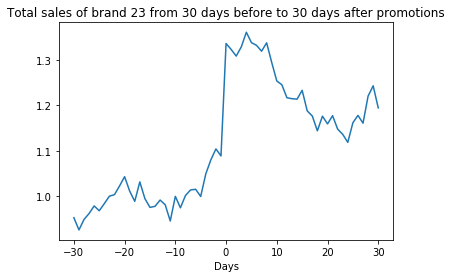

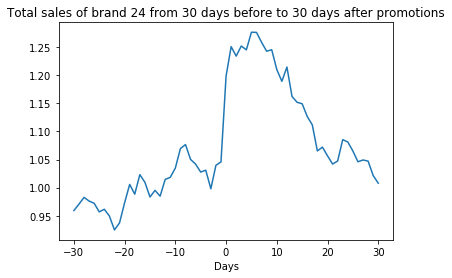

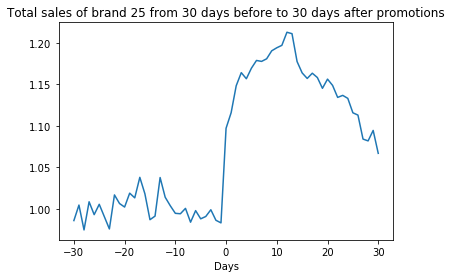

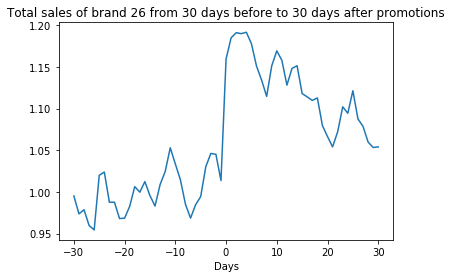

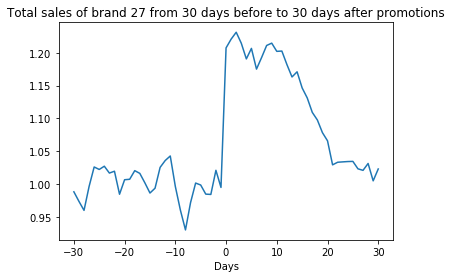

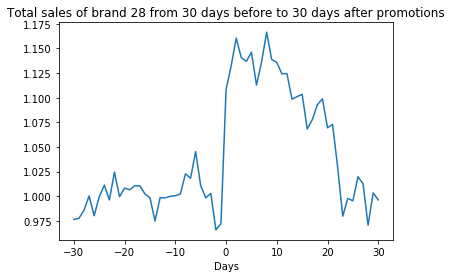

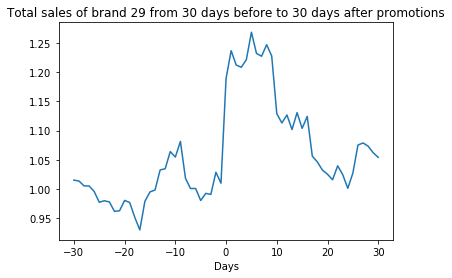

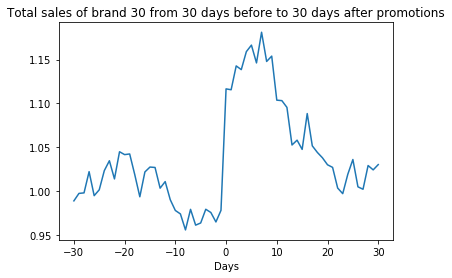

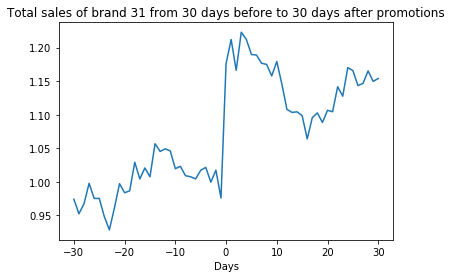

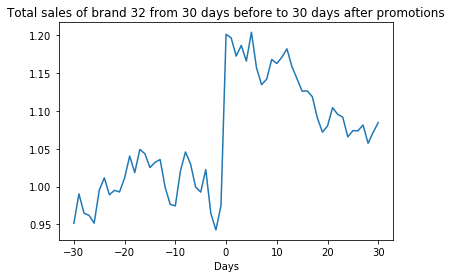

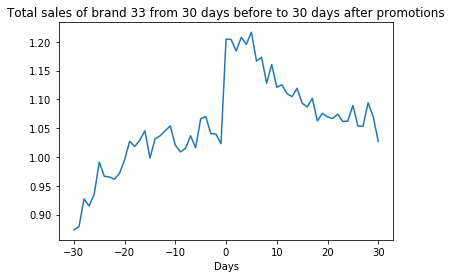

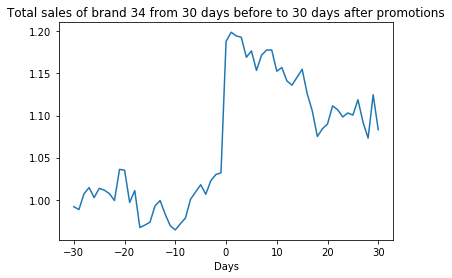

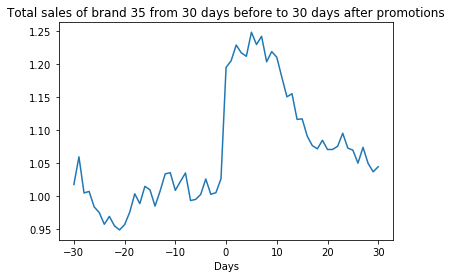

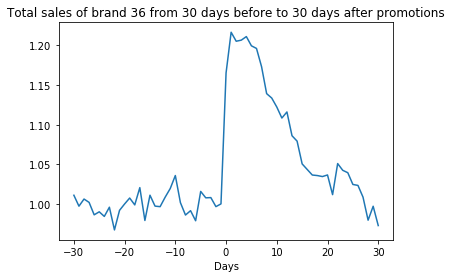

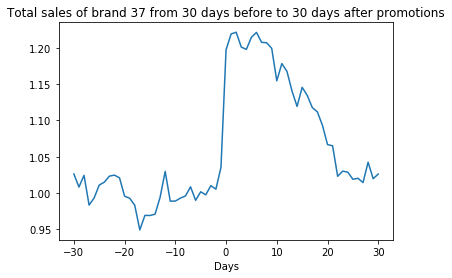

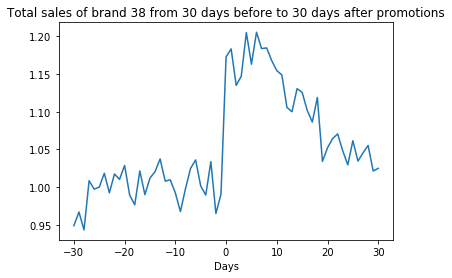

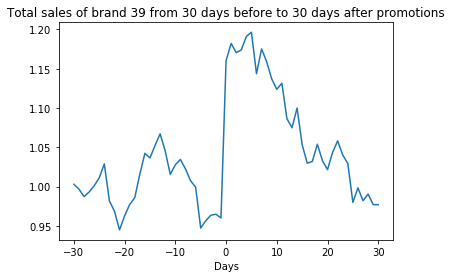

In [40]:
for i in range(40):
    brand_data = daily_sales[daily_sales['brand'] == i].sum()[2:]
    brand_dates = brand_promo[(brand_promo['brand'] == i)]['start_date'].tolist()
    brand_dates = [datetime.datetime.strptime(d, '%Y-%m-%d') for d in brand_dates]
    plotBrandPromotion(num_days = 30, my_dates = brand_dates, sales_total = brand_data, brand_num = i)

As shown above, given the time frame of 30 days before and 30 days after brand promotions, durations of aggregated brand promotions vary by brand. For example, total sales of brand 0 fall back to the sales level before brand promotions after about 20 days, while the durations of brand promotions of brand 1, 24, 39 are 15 days, 18 days, and 25 days respectively. 

It is also interested to see the duration of all brand promotions. As shown in the graph below, total sales of all brands seem to get back to its normal cycle 23 days after brand promotions.

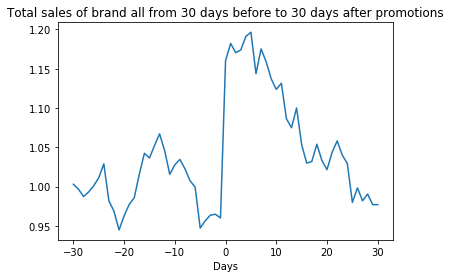

In [41]:
all_brand_data = daily_sales.sum()[2:]
all_brand_dates = brand_promo['start_date'].tolist()
all_brand_dates = [datetime.datetime.strptime(d, '%Y-%m-%d') for d in all_brand_dates]
plotBrandPromotion(num_days = 30, my_dates = brand_dates, sales_total = brand_data, brand_num = 'all')

### 3B. Multiple Linear Regression

For each brand, I computed the percent change in aggregated brand sales 5 days after vs. 5 days before the promotions. I then regressed this value against all predicting variables of marketing features. 

In [48]:
#i = promotion date
total_sales_by_brand = daily_sales.groupby('brand').sum().reset_index()
# Brand_PctChangeByDate
# Goal: return the percentage change of sales after promotion
# num_days: int, number of days before and after promotion 
# promot_date = list, a list of product promotion
# product_num = int, product
# --------------------------------------------------------
def Brand_PctChangeByDate(num_days, promo_date, brand_num):
    my_date = datetime.datetime.strptime(promo_date, '%Y-%m-%d')
    sales_date = [0 for i in range(num_days * 2)]
    date_index = all_dates.index(my_date)
    if date_index < num_days or date_index + num_days >= len(all_dates):
        return np.nan
    cur_brand_total = total_sales_by_brand[total_sales_by_brand.brand == brand_num].iloc[0][2:]
    for i in range(num_days * 2):
        sales_date[i] = cur_brand_total[date_index - num_days + i]
    avg_prior_sales = float(np.mean(sales_date[:num_days])) 
    avg_after_sales = float(np.mean(sales_date[num_days:])) 
    return (avg_after_sales / avg_prior_sales) - 1      

In [49]:
brand_promo.loc[:, 'sales_pct_change'] = \
    brand_promo.apply(lambda x: Brand_PctChangeByDate(num_days=5,
                                                   promo_date=x['start_date'],
                                                   brand_num=x['brand']), axis=1)

In [50]:
brand_promo.sales_pct_change.quantile(q=[0.1, 0.3, 0.5, 0.7, 0.9, 0.99])

0.10   -0.173684
0.30   -0.023086
0.50    0.087166
0.70    0.395409
0.90    2.611313
0.99    9.737989
Name: sales_pct_change, dtype: float64

In [51]:
brand_promo.sales_pct_change.quantile(q=[0.1, 0.3, 0.5, 0.7, 0.9, 0.99])
null_sales_pct_idx = brand_promo.sales_pct_change.isnull()
columns = ['f{}'.format(i) for i in range(30)]
X_brand = brand_promo[~null_sales_pct_idx][columns] 
## y means our output/dependent variable
y_brand = brand_promo[~null_sales_pct_idx]['sales_pct_change'] 
X_brand = sm.add_constant(X_brand) ## Add an intercept (beta_0) to our model

model = sm.OLS(y_brand, X_brand).fit() ## sm.OLS(output, input)
predictions = model.predict(X_brand)

# Print out the statistics
brand_model = model.summary()

In [52]:
print(brand_model)

                            OLS Regression Results                            
Dep. Variable:       sales_pct_change   R-squared:                       0.017
Model:                            OLS   Adj. R-squared:                  0.012
Method:                 Least Squares   F-statistic:                     3.387
Date:                Tue, 02 Oct 2018   Prob (F-statistic):           1.29e-09
Time:                        22:16:10   Log-Likelihood:                -13206.
No. Observations:                5989   AIC:                         2.647e+04
Df Residuals:                    5958   BIC:                         2.668e+04
Df Model:                          30                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const          1.3464      0.160      8.421      0.0

As shown above, the model has a low R-squared value of 0.017 indicating that this model explains 1.7% of the variance in our percent changes in sales before and after promotions. At 5% significance level, only the intercept is significant with p value < 0.05. This means that the act of having a promotion has a statistically significant impact on sales, but no specific marketing feature contributes significantly to the impact of promotions. 


## 4. Products

For each product, I computed the percent change in aggregated brand sales 5 days after vs. 5 days before the promotions. I then regressed this value against all predicting variables of marketing features. 

In [53]:
# Product_PctChangeByDate
# Goal: return the percentage change of sales after promotion
# num_days: int, number of days before and after promotion 
# promot_date = list, a list of product promotion
# product_num = int, product
# --------------------------------------------------------
def Product_PctChangeByDate (num_days, promo_date, product_num): 
    my_date = datetime.datetime.strptime(promo_date, '%Y-%m-%d')
    sales_date = [0 for i in range(num_days * 2)]
    date_index = all_dates.index(my_date)
    if date_index < num_days or date_index + num_days >= len(all_dates): 
        return np.nan
    cur_product_total = daily_sales[daily_sales['product'] == product_num].iloc[0][2:]
    for i in range(num_days * 2): 
        sales_date[i] = cur_product_total[date_index - num_days + i]
    avg_prior_sales = float(np.mean(sales_date[:num_days]))
    avg_after_sales = float(np.mean(sales_date[num_days:]))
    if avg_prior_sales == 0:
        return np.nan
    return (avg_after_sales / avg_prior_sales) - 1

In [54]:
product_promo.loc[:, 'sales_pct_change'] = product_promo.apply(lambda x: Product_PctChangeByDate(num_days = 5,
                                                  promo_date=x['start_date'],
                                                  product_num = x['product']), axis = 1)

In [55]:
product_promo.sales_pct_change.quantile(q=[0.1, 0.3, 0.5, 0.7, 0.9, 0.99])

0.10     0.000000
0.30     0.776816
0.50     1.498084
0.70     2.466508
0.90     6.976417
0.99    50.761667
Name: sales_pct_change, dtype: float64

In [56]:
product_null_sales_pct_idx = product_promo.sales_pct_change.isnull()

In [57]:
columns = ['f{}'.format(i) for i in range(30)]

In [367]:
#product_promo.head()

In [58]:
X_product = product_promo[~product_null_sales_pct_idx][columns]
y_product = product_promo[~product_null_sales_pct_idx]['sales_pct_change']

In [59]:
X_product = sm.add_constant(X_product)
model = sm.OLS(y_product, X_product).fit()
predictions = model.predict(X_product)
product_model = model.summary()

In [60]:
print(product_model)

                            OLS Regression Results                            
Dep. Variable:       sales_pct_change   R-squared:                       0.006
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     4.552
Date:                Tue, 02 Oct 2018   Prob (F-statistic):           1.74e-15
Time:                        22:20:50   Log-Likelihood:                -96627.
No. Observations:               23644   AIC:                         1.933e+05
Df Residuals:                   23613   BIC:                         1.936e+05
Df Model:                          30                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const          5.5122      0.523     10.548      0.0

As shown above, the model has a low R-squared value of 0.006 indicating that this model explains 0.6% of the variance in our percent changes in sales before and after promotions. At 5% significance level, only the intercept is significant with p value < 0.05. This means that the act of having a promotion has a statistically significant impact on sales, but no specific marketing feature contributes significantly to the impact of promotions. 